## The dataset and packages

You can find the data used in this project here: https://www.kaggle.com/datasnaek/chess . This dataset contains  20,058 records and 16 variables. The original kaggle poster took these data from lichess.org. Each record corresponds to a chess match, and all records were taken from the top 100 teams playing on lichess.org. 

We will mostly use Python's data packages (pandas, sci-kit, etc.). Otherwise, we will be using my own python module (chess_utility, also in this folder) that will contain more complex code. For Jupyter Notebook users, recall you can type any function signature followed by ?? to see the full function source code and documentation.  

In [1]:
import pandas as pd
import numpy as np

import chess_utility as cu

import seaborn as sns
sns.set_style("dark")    # Because we're cool
import matplotlib.pyplot as plt
%matplotlib inline

Here we can see a small random portion of the data. 

In [2]:
games = pd.read_csv('games.csv')

In [3]:
NUMROWS = 2
cu.sample_entries(games, NUMROWS, games.columns)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
6858,XxkHBPg8,True,1.498990e+12,1.498990e+12,46,mate,black,10+0,anakgreget,1645,saladrocket,1748,e4 c5 Nc3 d6 Nf3 Nc6 Bc4 e6 O-O Be7 d4 cxd4 Nx...,B23,Sicilian Defense: Closed Variation,3
10076,jPrhClhZ,True,1.407562e+12,1.407563e+12,65,mate,white,9+0,thecastle,1765,gar,1654,b3 e5 Bb2 Nc6 e3 Nf6 Bb5 a6 Bxc6 dxc6 Bxe5 Ng4...,A01,Nimzo-Larsen Attack: Modern Variation #4,5


The variables do an excellent job of explaining themselves. Non-chess players, however, might need some insight into what a few of these variables measure. 

- Turns refers to the number of turns the game has undergone. One full turn is two moves since each player moving once counts as a turn. 
- The increment_code variable refers to time increments in a game. Most chess games nowadays have a time limit for each player to make their moves. Time increments indicate how much extra time a player acquires when it's their turn to move. For example, a time increment of 15 + 0 indicates each player has 15 minutes to make all their moves, and 0 seconds will be added to their elapsed time each time it's their turn to move. A time increment of 15 + 10 indicates the same thing, except now, each time it's a player's turn, they will get a bonus 10 seconds on the clock. 
- Note that the opening_eco refers to a specific code used to classify a chess opening, the first few moves in a chess game. 
- White_id and black_id refer to usernames for the players on lichess.org. 
- Finally, white_rating and black_rating correspond to the strength level of a player. A higher number indicates a stronger player. Lichess.org use the Glicko2 system for their ratings. 

After glancing over our stock of variables, we swiftly check for dreaded missing values in each of them.

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


At the top of the output, we see 20058 entries for the entire data set. If we pore over the second column, *non-null count*, we see no variable has missing values since all demonstrate 20058 as their non-null count. So we can safely conclude our data set has no missing values. 

Before performing an exploratory data analysis (EDA) on our dataset, we will define a predictive question for the set and then perform an EDA for the variables that interest us. 

## The predictive mega question

After poring over the data, we are seduced by the idea of predicting the outcome of a chess match using player ratings. A chess rating (see above, white_rating and black_rating) indicates strength of a player. After signing up on the site, lichess.org gives a user a provisionary rating of 1300. As they play more games, the user gets a more accurate rating. Since all of our matches come from the top 100 teams in lichess.org, we can assume these ratings reflect player strengths well. 

So, how could we use ratings to predict the outcome of a match? The simplest way is by taking a difference between two ratings. Low differences indicate evenly matched players while high differences suggest unevenly matched players. We would aim to predict the outcome of a match based on this difference. Particularly, we could show a probabilty of winning for each player based on the difference between their ratings.  

It might also be useful to consider turns and "whiteness" of a player. Supposing a match had been going on for 5 turns, this might inform how likely a player is to win versus a match having been going on for 20 turns. Whiteness also matters since white is first to move in a game. So, playing as white against a higher rated player might up your chances of winning. 

Our question, thus, can be concisely worded as the following: can we use ratings, number of turns, and whether a player is white to assign a probability of winning to each player in a chess match?

*Nothing up this sleeve, and nothing up this sleeve* so we'll jump right in.

## Cooking new variables

To answer our predictive question, we make new variables to work with. 

1) abs_diff_rating will take the absolute value of the difference in rating between two players. An absolute value makes sense in our context since we'll only be interested in the magnitude of difference between two player ratings.

In [5]:
games['abs_diff_rating'] = np.abs(games.white_rating - games.black_rating)

2) higher_rating_won will be a binary variable taking 1 if the person with the higher rating won, and 0 if they didn't. We'll use this variable when running a binary model. 

In [6]:
# To make higher_rating, I make a variable that determines who won - white or black, or if the match was a draw. 
games[ 'higher_rating' ] = ''
games.loc[ games.white_rating - games.black_rating > 0, 'higher_rating' ] = 'white'
games.loc[ games.white_rating - games.black_rating < 0, 'higher_rating' ] = 'black'
games.loc[ games.white_rating - games.black_rating == 0, 'higher_rating' ] = 'same'

In [7]:
games[ 'higher_rating_won' ] = 0
games.loc[ games.winner == games.higher_rating, 'higher_rating_won'] = 1

3) result will encode whether the higher rated player lost, tied, or won (0, 1, 2). We'll use this variable when running a three class classifier. 

In [8]:
games[ 'result'] = 0
games.loc[ games.winner == 'draw' , 'result'] = 1
games.loc[ games.higher_rating_won == 1, 'result'] = 2

4) white_higher_rated encodes whether the higher rated player was white or not (1, 0). 

In [9]:
games[ 'higher_rated_white' ] = 0
games.loc[ games.higher_rating == 'white', 'higher_rated_white' ] = 1

Here's a look at a random sample of our data set for the variables we created. We also include variables in the call out to check the variables were created properly.

In [10]:
made_variables = ['abs_diff_rating', 'higher_rating_won','result', 'higher_rated_white']
comparison_variables = ['winner', 'white_rating', 'black_rating']
cu.sample_entries(games, NUMROWS, made_variables + comparison_variables)

,abs_diff_rating,higher_rating_won,result,higher_rated_white,winner,white_rating,black_rating
4789,40,0,0,0,white,1294,1334
16435,250,1,2,1,white,1997,1747


*Note: since each call to sample_entries is random, you can run the cell above repeatedly to get different samples from the dataset.*

Next, we'll drop all other variables and be left with a spartan dataset containing only the variables interesting to us. 

In [11]:
new_variable_indices = [ games.columns.get_loc( column ) for column in made_variables ]

In [12]:
modified_games = games.iloc[ :, new_variable_indices ].copy()

In [13]:
modified_games[ 'turns' ] = games[ 'turns' ]

In [14]:
# Check work 
modified_games.head()

,abs_diff_rating,higher_rating_won,result,higher_rated_white,turns
0,309,1,2,1,13
1,61,0,0,1,16
2,4,0,0,0,61
3,15,0,0,0,61
4,54,1,2,1,95


I then save this modified version of the dataset and reset my games variable to reflect the modified version. 

In [15]:
modified_games.to_csv( 'modified_games.csv' )

In [16]:
games = modified_games

## Exploratory Data Analysis

In this section, we examine our variables of interest with a statistical magnifying glass. 

### Absolute value in differences
We'll start by checking out our abs_diff_rating variable. 

In [17]:
games.abs_diff_rating.describe()

count    20058.000000
mean       173.091435
std        179.214854
min          0.000000
25%         45.000000
50%        115.000000
75%        241.000000
max       1605.000000
Name: abs_diff_rating, dtype: float64

A brief look at the read out lets us know most observations had an absolute difference of up to 241 points (third quantile reading). Below, we can see a histogram of this distribution. 

Text(0.5, 0, 'Absolute Value Difference in Rating')

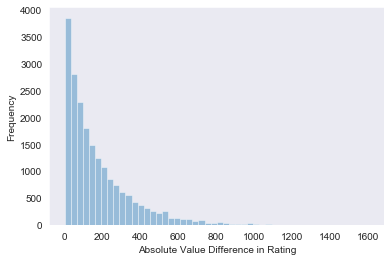

In [18]:
sns.distplot(games.abs_diff_rating,
                        kde=False)
plt.ylabel('Frequency')
plt.xlabel('Absolute Value Difference in Rating')

We've got a right skewed distribution of absolute values in rating. This skew graphically shows how most games took place between players having smaller absolute difference in rating.

A box plot helps us visualize possible outliers.

Text(0.5, 0, 'Absolute Value Difference in Rating')

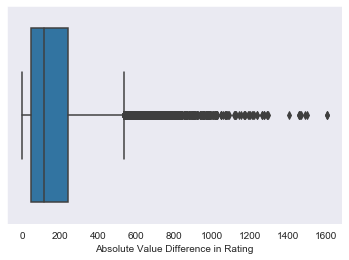

In [19]:
sns.boxplot(x="abs_diff_rating", data=games)
plt.xlabel('Absolute Value Difference in Rating')

It looks like at around the 600 absolute value difference, we have a hoard of high outliers. We need not, however, remove them yet since they could inform how large differences contribute to percentages of winning. Note that we don't have low outliers since all of our values are positive. 

Let's find out how many of these high outliers we have.

In [20]:
# We use the boxplot definition of outliers inline with our plot above.
quartiles = np.percentile(games.abs_diff_rating, [25, 50, 75])
upper_cutoff = games.abs_diff_rating.mean() + 1.5 * ( quartiles[2] - quartiles[0] )

In [21]:
np.round(upper_cutoff)

467.0

Our upper cutoff tells us that any game having an absolute difference greater than 467 can be consider an outlier. 

In [22]:
games.loc[games.abs_diff_rating > upper_cutoff, 'abs_diff_rating']

7        695
11       486
12       555
20       582
26       746
        ... 
19921    771
20012    768
20041    507
20042    494
20053    471
Name: abs_diff_rating, Length: 1491, dtype: int64

So, we have 1491 outliers.

I'm curious. Do these big differences in rating have a high proportion of wins for the higher rated player? 

In [23]:
games.loc[games.abs_diff_rating > upper_cutoff, 'higher_rating_won'].value_counts()

1    1257
0     234
Name: higher_rating_won, dtype: int64

Recall that a value of 1 means the higher rated player won, 0 if they drew or lost. Thus, we can interpret this as saying that in these outlier games, 1257 matches resulted in a win for the higher rated player, while 234 of those matches resulted in a loss. As a proportion, we have:

In [24]:
games.loc[games.abs_diff_rating > upper_cutoff, 'higher_rating_won'].value_counts(1)

1    0.843058
0    0.156942
Name: higher_rating_won, dtype: float64

So do we give the outliers the boot? Nope. Seeing high absolute differences makes sense since matches get created randomly in lichess.org. Also, high absolute differences could inform the probability for the match outcome. 

### Higher Rating Won

We are interested in checking out how often the higher rating won since this will be one of our response variables in our predictions. 

Text(0.5, 0, 'Higher Rating Won')

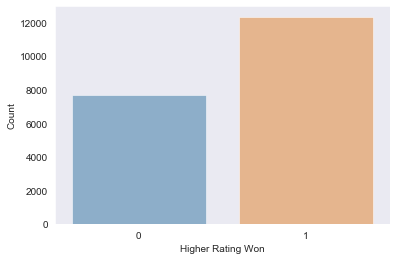

In [28]:
sns.countplot(x = 'higher_rating_won', data = games,  alpha = 0.5)
plt.ylabel('Count')
plt.xlabel('Higher Rating Won')

Below is a specific numerical proportion.

In [29]:
games.higher_rating_won.value_counts(1)

1    0.615814
0    0.384186
Name: higher_rating_won, dtype: float64

So 61% of the time, the higher rating won.

### Number of turns

We also check out the distribution for the number of turns taken. 

Text(0.5, 0, 'Turns')

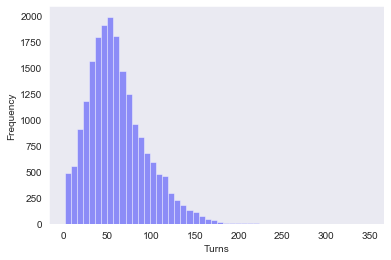

In [25]:
sns.distplot(games.turns, kde = False, color = 'b')
plt.ylabel('Frequency')
plt.xlabel('Turns')

Looks like most turns hover around 50. A numerical distribution is shown below.

In [31]:
games.turns.describe()

count    20058.000000
mean        60.465999
std         33.570585
min          1.000000
25%         37.000000
50%         55.000000
75%         79.000000
max        349.000000
Name: turns, dtype: float64

We get a mean and a median that are similar at 60 (rounded down from 60.46 since turns have to be whole numbers) and 55 respectively. Seeing 349 for a max number of turns makes me curious. What more can I say about that match?

In [26]:
games.iloc[games.turns.max()]

abs_diff_rating        20
higher_rating_won       0
result                  0
higher_rated_white      1
turns                 120
Name: 349, dtype: int64

The players had similar ratings showing only 20 points difference. Also, black won since the higher_rated_won variable lets us know the higher rated (white) player didn't win. 

Don't know if you noticed saw this, Watson, but we had a minimum of 1 for turns (look out our output for numerical description of turn data). This is alarming since a 1 turn game would probably not provide useful information. 

We need to determine a good cut off for how many turns is acceptable in our set. In chess, the fastest check mate is called the Fool's Mate and can happen in two turns. So a cut off of two turns for a likely game would be acceptable for a realistic match. 

We can check how many games lasted less than two turns. 

In [38]:
len( games.loc[ games.turns < 2 ] )

0

Let's remove games with less than 2 turns from our data. 

In [37]:
games.drop(games[games.turns < 2].index, inplace = True)

### Result 

Let's look at the result variable. Recall that this variable encodes whether the higher rated player lost (0), drew (1), or won (2). 

Text(0.5, 0, 'Result')

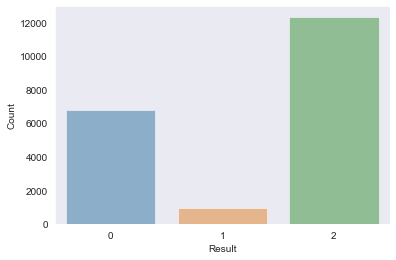

In [39]:
sns.countplot(x = 'result', data = games, alpha = 0.5)
plt.ylabel('Count')
plt.xlabel('Result')

For the higher rated player, we have mostly wins (2), a little more than half of these are losses (0), and a small proportion turn out to be draws (1). We can see numerical proportions below.

In [40]:
games.result.value_counts(1)

2    0.615669
0    0.336926
1    0.047405
Name: result, dtype: float64

The higher rated player won 61% of the time, lost 34% of the time, and drew about 5% of the time.

### Exploratory Data Analysis Summary

1) We need not worry about low outliers in the absolute value of differences between ratings. High outliers, however, do exist (according to our definition of boxplot outliers), and we will deal with them based on the models we apply to the data. 

2) For the higher rated player, most of the games end up as wins ~61%, then losses ~34%, and a tiny percentage of the matches are draws ~5%. 

3) The turns variable revealed short turn games, and we removed any matches that had less than 2 turns. 

Since we removed turns outliers from the data, we will re-write out the dataset for later use. 

In [41]:
games.to_csv('modified_games.csv')

## Getting the plan straight

After going through the grand experience of the EDA, you may have forgotten what kind of modelling wonders we're trying to do. So here's the dealio again. 

We imagine we're sitting down to play a chess match. Since we're both pretty bad ass, we've already racked up some kind of rating. We'll say you've been practicing more so you're now touting that higher rating. What's the chance that you'll end up winning? What if you're playing as white instead of black? What if the game has been going on for like a bajillion moves now?

Using Python's groovy machine learning libraries, we'll answer these dire questions. 

We'll get cracking on predicting wins and losses (binary case) for the higher rated player first. 

## Cooking up binary models

#### Normalization, response setting, and other params

Before fitting models, we will normalize our data. This matters because we intend on using multiple predictors, and our predictors could be on different scales. We'll knight these predictors with a big 'X' for a name. 

In [47]:
from sklearn.preprocessing import normalize
X = normalize(games[ [ 'abs_diff_rating', 'turns', 'white_higher_rated' ] ])

In [51]:
games = pd.read_csv('games_new_vars.csv')

We set up a response and give it a wildly descriptive 'y'. 

In [52]:
y = games[ 'higher_rating_won' ]

Some of the algorithms below automatically randomize. So, if we're not careful, we could end up always getting different numbers for the model results. By setting a RANDOM STATE, we can pick a result and stick with throughout the analysis. Also, when we cross validate using K fold cross validation we will specify 10 folds through NUMBER FOLDS. 

In [53]:
RANDOM_STATE = 1
NUMBER_FOLDS = 10

#### Logistic regression

We will begin with a Logistic Regression and perform a stratifed 10 fold cross validation on the model. 

In [54]:
lg_confusion_matrix = cu.run_logistic_regression(NUMBER_FOLDS, X, y, RANDOM_STATE)
lg_results = cu.get_cm_results(lg_confusion_matrix)

#### Tree based methods

Next up, we fit a bag of trees to our data. In the case of fitting a bag of trees and a random forest, we will use 100 estimators. This means that we will be using 100 trees in each case to build the models. 

In [55]:
NUMBER_ESTIMATORS = 100

In [56]:
bag_confusion_matrix = cu.run_bag_trees(NUMBER_FOLDS, NUMBER_ESTIMATORS, RANDOM_STATE, X, y)
bag_results = cu.get_cm_results(bag_confusion_matrix)

In [57]:
r_forest_confusion_matrix = cu.run_random_forest(NUMBER_FOLDS, NUMBER_ESTIMATORS, RANDOM_STATE, X, y)
r_forest_results = cu.get_cm_results(r_forest_confusion_matrix)

#### Results readings

How did our beautiful models do? We can plot a confusion matrix for each model and gaze in wonder. 

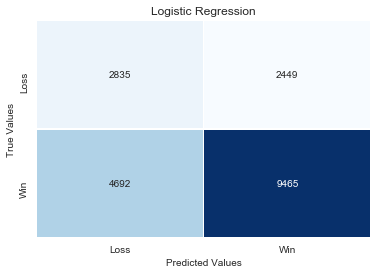

In [58]:
cu.create_cm_plot( 'Logistic Regression', lg_confusion_matrix )

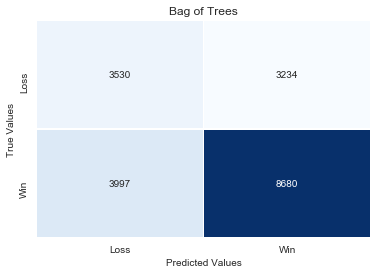

In [59]:
cu.create_cm_plot( 'Bag of Trees', bag_confusion_matrix )

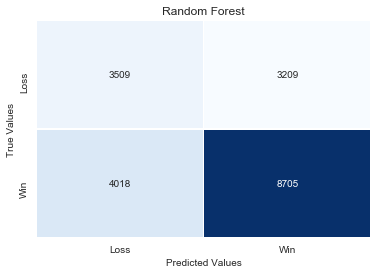

In [60]:
cu.create_cm_plot( 'Random Forest', r_forest_confusion_matrix )

In case you're rusty on the magic of confusion matrices, recall that confusion matrices help us determine how well the model performed by comparing our guesses to the truth and nothing but the truth. After admiring the excellent shades of blue, you will probably notice the bottom right hand square in the matrices above. This square denotes an accuracte prediction for wins, and it looks like the models do very well when predicting wins. 

A whole tribe of metrics based on a confusion matrix exist. We'll acquire these then plot these to determine more specific model performance.

In [61]:
accuracy, precision, recall, fmeasure, specificity, negative_pv = cu.group_important_results(lg_results, bag_results, r_forest_results)

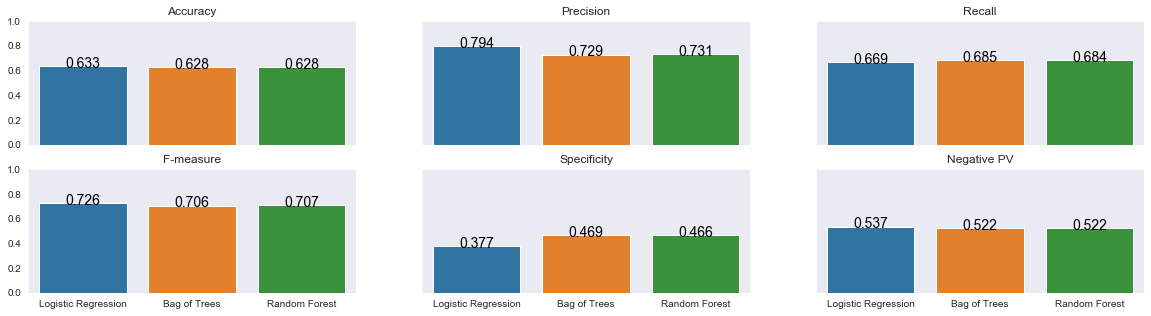

In [62]:
cu.create_specific_results_plot(r_forest_results, lg_results, bag_results, 3, 2) # 3 cols, 2 rows

We've got six different metrics to chew on here so put on your seat belt. 

- First, is accuracy. This is a general metric. It tells us how often the model correctly predicts the value. It's not hard to see that all models seem to hover at around 62% of accuracy. In other words, the model makes a good prediction (good boy!) 62% of the time. 

- Second, is precision. This tells us how often the model predics a win. Here, the Logistic Regression pulls ahead at 0.794 and says cheers to the other two models.  

- Third, is recall. This tells us how accurately we predicted the wins. Our models seem to hover at around 68%. 

- Fourth, is the famous fabulous fmeasure. This combines precision and recall into one spiffy measurement. In our case, it looks like most models however around 70%. 

- Fifth, is specificity. The specifics on specificity are simple. The measure let's us know stuff about losses. In particular, out of the times we predicted a loss how often were we right? And, goodness gracious the Logistic Regression just sags here at only 37% compared to the others at around 46%. 

- Finally, we got negative pv. This is short for negative predictive value, and this tells us what percentage of true losses our models caught. Most of the models do equally pitifully at around 52%.  

##### Conclusion
So what can we say? These models perform similarly across most measurements. The models do splendidly when they predict wins (Logistic Regression in particular), but they trip awkwardly when predicting losses (Logistic Regression in particular). 

We could also compare with the null rate. This measures the accuracy if we just predicted every response to the dominant class. Using different word words, this is the accuracy of a model that simply predicts a win no matter what. 

In [63]:
null_rate = np.abs( (y - 1 ).sum() ) / len( games )
null_rate

0.3871714417982614

And it is cute, and encouragingly, worse than the accuracy of any of our models above. 

For those pursuing extra credit, we also show plots for each model packaged with its confusion matrix measurements.

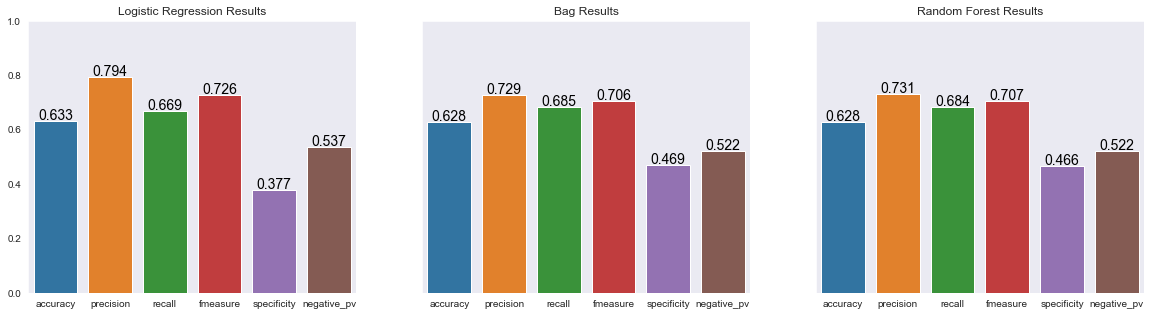

In [64]:
cu.create_cumulative_results_plot(r_forest_results, lg_results, bag_results)

They look like they all pretty similar. 

## Beyond binary 

In this section, we go to town. We refit our tree based models with our response will as 'result'. Recall this encoded whether games were a loss, draw, or win for the higher rated player. We eschew trying a three class classification with a logistic regression 'cuz it isn't a popular choice. 

In [65]:
y = games['result']

#### Bag those Trees

We kick it off again a bag of trees. Here, we also run stratified 10 fold cross validation.  

In [66]:
bag_multi_confusion_matrix = cu.run_bag_trees(NUMBER_FOLDS, NUMBER_ESTIMATORS, RANDOM_STATE, X, y)

We also fit the random forest in exactly the same way. 

In [67]:
r_forest_multi_confusion_matrix = cu.run_random_forest(NUMBER_FOLDS, NUMBER_ESTIMATORS, RANDOM_STATE, X, y)

We can start by comparing the accuracy of our two models. 

In [68]:
r_forest_accuracy = cu.get_accuracy_three_class( r_forest_multi_confusion_matrix )
bag_accuracy = cu.get_accuracy_three_class( bag_multi_confusion_matrix )
accuracies = {'Random Forest': r_forest_accuracy, 'Bag of Trees': bag_accuracy}

(0, 1)

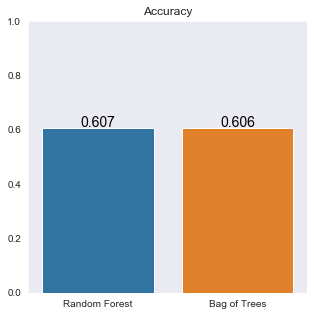

In [69]:
fig, axs = plt.subplots(figsize=[5, 5], gridspec_kw={'wspace': 0.2})
cu.create_bar_results(accuracies, 'Accuracy', axs)
plt.ylim([0, 1])

Our hearts say 'bummer'. They classify correctly about 60% of the time. We, however, don't immediately lose hope since maybe more specific metrics will uplift us. 

In a three class confusion matrix, we usually consider precision and recall for each class. So, we'll join the herd and do so as well. 

##### Loss

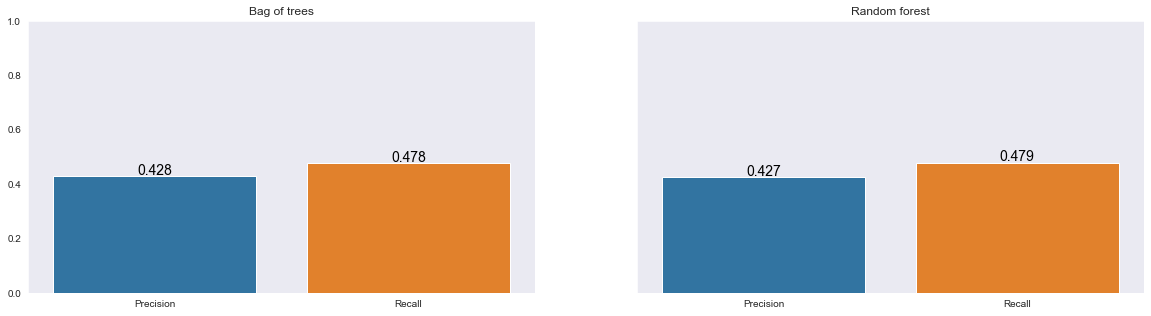

In [70]:
cu.make_plot_multi_label( bag_multi_confusion_matrix, r_forest_multi_confusion_matrix, 0 )    # 0 for loss

Uncannily, the precision and recall is quite similar for the bag and forest. This considers the losses predicted by the model. So, when we predict a lost, we are right around 43% of the time (precision). But out of all the losses we should've predicted, we only got 48% (recall). 

##### Draw

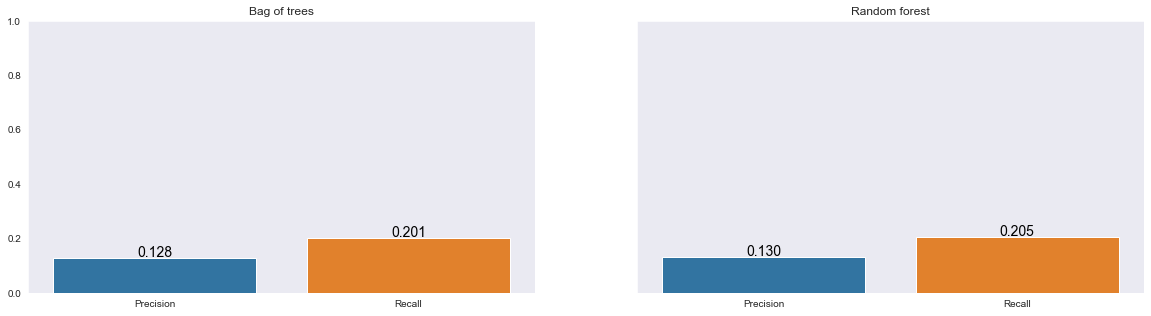

In [71]:
cu.make_plot_multi_label( bag_multi_confusion_matrix, r_forest_multi_confusion_matrix, 1 )    # 1 for draw

Egad. Our models sink to new lows when trying to predict a draw between the two players. When we predict a draw, we are right about 13% of the time (precision). Also, out of all the draws we should've predicted, we only got 20% (recall). 

##### Winning

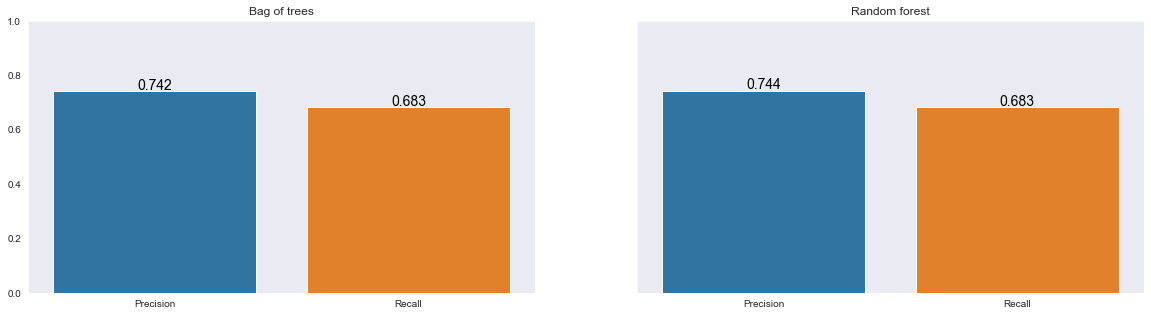

In [72]:
cu.make_plot_multi_label( bag_multi_confusion_matrix, r_forest_multi_confusion_matrix, 2 )    # 2 for win

Applauds wildly. Our models rise to new heights when predicting wins. When we predict a win, we are right around 74% of the time (precision). But out of all the wins we should've predicted, we only properly predicted 68% (recall). 

##### Conclusion

So, we can say our model wins at predicting wins, loses at predicting losses, and jumps off a cliff when trying to predict draws. 

## Looking back fondly

This wraps up our analysis. Although the models do well when predicting wins, further work will need to be done if we want them to win at predicting losses and draws. Also note how the bar graphs gave off orange and blue, just like my alma mater completely by accident. Or was it an accident?

## Now what

A recent one person survey said that 100% of me was thankful for your taking the time to peruse this document. 

You may be wondering what do now. I suggest watching dance videos on youtube. But say you wanted to see the next episode of this chess analysis, I would probably attempt to better the predictive models by: 

- Using more predictors (like the kinds of openings used). It's possible that other predictors could give more determining info about wins. 

- Getting my hands on more observations. This data set carried almost 20 000 records. What if tried this with 200 000 or 1 000 000 000 records. That would be cool.   

- Trying new models. There's a whole zoo of models out there, and we only visited the logistic regression and trees. Perhaps an additive GLM. Or a neural network. 

- It's possible that the models do poorly with losses and draws because not many losses and draws are present in the data. Perhaps bootstrapping loss and draw data would help the models. (I'm just freestyling here). 

## Cheers

I'm currently my own agent so if you liked this drop me a line and let me know whassup. Wishing you a splendid day.